# Variance Reduction Methods : the case of Basket Option

## Pricing a Basket Option: Experimental Study

In this notebook, we explore the pricing of a European basket option using various Monte Carlo methods.  
We start with a simple toy example to validate our implementation and understand the behavior of different variance reduction techniques.  

The methods implemented include:
- **Naive Monte Carlo**: baseline estimation of the basket option price.
- **Non-Conditonal Variate Control using Geometric Basket** : using a geometric basket option to reduce the variance.
- **Non-Conditional Variate Control (NVC)**: applying Curran(1994) method to reduce variance.
- **Conditional Variate Control with Correction (NVC_C)**: refined NVC estimator with additional correction. (Sun and Xu (2018))

We will analyze the performance of these methods by computing the variance reduction factor and comparing the convergence of the estimators.  
Later, we will extend this study to **real market data** and perform a detailed experimental analysis, varying base parameters to assess the robustness of our methods.  
The results will be summarized in a final PDF report.

We use functions defined in Variance_reduction.py. The first one, montecarlo, takes a vector of Monte Carlo simulations and returns the corresponding estimator. The second function generates Monte Carlo simulations from the initial parameters, according to the four methods presented

In [1]:
from Variance_reduction import montecarlo, montecarlo_estimators, plot_variance_ratios
import numpy as np
import matplotlib.pyplot as plt

This is our initial parameters, chosen in a rather naive way with the goal of getting first familiar with the theory

In [2]:
N = 100000
d = 4  
S0 = np.array([100, 95, 105, 110])  
sigma = np.array([0.2, 0.25, 0.18, 0.22])  
r = 0.05 
T = 2
K = 100
w = np.array([0.25, 0.25, 0.25, 0.25]) 

R = np.array([
    [1.0, 0.8, 0.6, 0.4],
    [0.8, 1.0, 0.65, 0.75],
    [0.6, 0.65, 1.0, 0.5],
    [0.4, 0.75, 0.5, 1.0]
])

proba = 0.95 #It indicates the probability that the derivative’s price lies within the confidence interval.

In [3]:
MC, VC, NVC, NVC_C  = montecarlo_estimators(N, d, S0, sigma, r, T, K, w, R)

## Pricing a Basket Option with Naive Monte Carlo

We estimate the price of a European basket option by simulating the terminal asset values.  

The basket payoff is:

$$
\max\Big(\sum_{i=1}^{d} w_i S_i(T) - K, 0\Big)
$$

The option price is estimated as the discounted average of the simulated payoffs:

$$
C_0 \approx e^{-rT} \frac{1}{N} \sum_{j=1}^{N} h\big(S^{(j)}\big)
$$

This naive Monte Carlo approach provides a baseline before applying variance reduction techniques.

Note : Here, we work with a toy example, real market data will be used later.

In [4]:
start_idx = int(N/10)

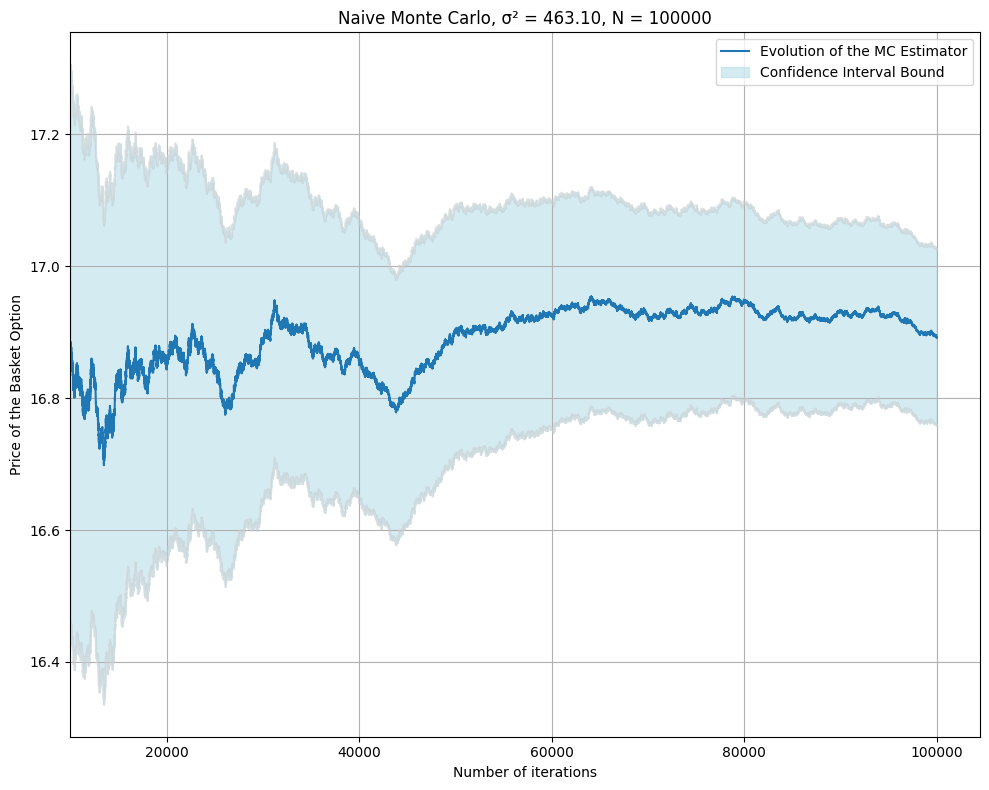

In [5]:
monte_carlo_estimator, asymptotic_variance, bound = montecarlo(MC, proba, with_interval_bounds = True)
x = np.arange(start_idx, len(monte_carlo_estimator))

upper_bound = monte_carlo_estimator + bound
lower_bound = monte_carlo_estimator - bound

fig,ax = plt.subplots(layout = "tight", figsize = (10,8))
ax.plot(x, monte_carlo_estimator[start_idx:], label = "Evolution of the MC Estimator", color = "C0")
ax.plot(x, upper_bound[start_idx:], color = "lightgrey", alpha = 0.5)
ax.plot(x, lower_bound[start_idx:], color = "lightgrey", alpha = 0.5)
ax.fill_between(x, upper_bound[start_idx:], lower_bound[start_idx:], color='lightblue', alpha=0.5, label="Confidence Interval Bound")
ax.set_title(f"Naive Monte Carlo, σ² = {asymptotic_variance:.2f}, N = {N}")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Price of the Basket Option")
ax.legend()
ax.grid(True)

plt.xlim(start_idx)
plt.show()


## Pricing a Basket Option Using a Geometric Control Variate

We now improve our Monte Carlo estimation by using a control variate based on the geometric basket option.  
The geometric basket has a closed-form solution, which allows us to reduce the variance of our estimator.  

Let the geometric basket payoff be:  
$$
 \max\Big(\prod_{i=1}^d S_i(T)^{w_i} - K, 0\Big)
$$

We combine the naive Monte Carlo payoff with the geometric control variate to get a more accurate estimate of the option price.  
This method serves as a first step toward variance reduction before tackling more sophisticated techniques.


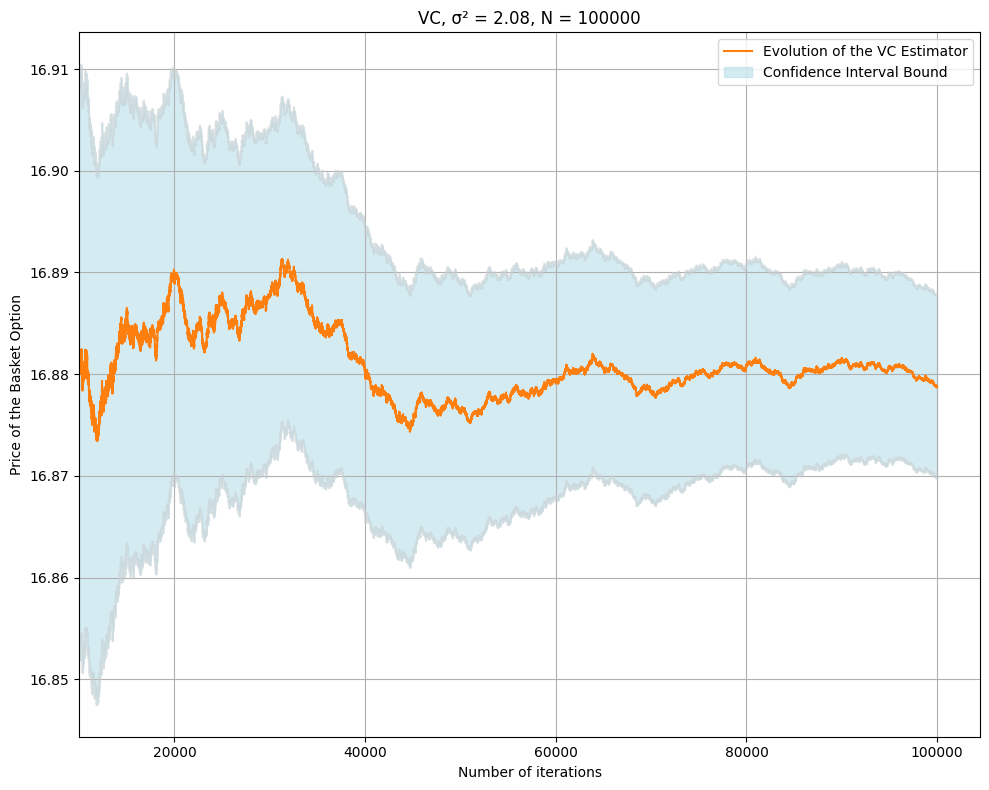

In [6]:
monte_carlo_estimator_VC, asymptotic_variance_VC, bound = montecarlo(VC, proba, with_interval_bounds = True)
x = np.arange(start_idx, len(monte_carlo_estimator_VC))

upper_bound_VC = monte_carlo_estimator_VC + bound
lower_bound_VC = monte_carlo_estimator_VC - bound

fig,ax = plt.subplots(layout = "tight", figsize = (10,8))
ax.plot(x, monte_carlo_estimator_VC[start_idx:], label = "Evolution of the VC Estimator", color = "C1")
ax.plot(x, upper_bound_VC[start_idx:], color = "lightgrey", alpha = 0.5)
ax.plot(x, lower_bound_VC[start_idx:], color = "lightgrey", alpha = 0.5)
ax.fill_between(x, upper_bound_VC[start_idx:], lower_bound_VC[start_idx:], color='lightblue', alpha=0.5, label="Confidence Interval Bound")
ax.set_title(f"VC, σ² = {asymptotic_variance_VC:.2f}, N = {N}")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Price of the Basket Option")
ax.legend()
ax.grid(True)

plt.xlim(start_idx)
plt.show()

# Curran (1994) Splitting Method

We now implement Curran's (1994) method using a control variate based on the payoff $(A-K)^+$ when $G > K$.  
The idea is that a closed-form formula exists for this part of the payoff, which often coincides with the basket payoff, leading to better variance reduction.

Let $G$ be the geometric average of the basket:  

$$
G = \exp\Big(\sum_{i=1}^n w_i \ln(S_i(T))\Big)
$$  

Using the control variate $(A-K)^+ 1_{\{G>K\}}$, the basket option price can be split as:

$$
V = e^{-rT} \left( \mathbb{E}[(A-K) 1_{\{G>K\}}] + \mathbb{E}[(A-K)^+ 1_{\{G<K\}}] \right)
$$  

This method uses the part we can compute exactly to make the Monte Carlo estimate more accurate.

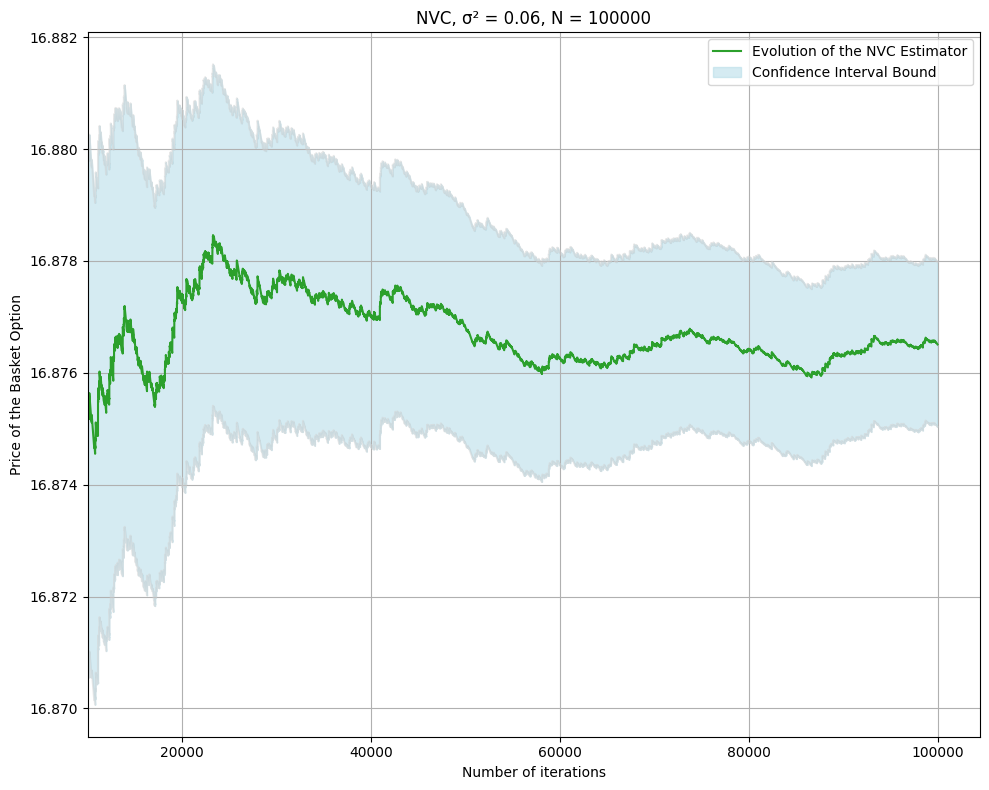

In [7]:
monte_carlo_estimator_NVC, asymptotic_variance_NVC, bound = montecarlo(NVC, proba, with_interval_bounds = True)
x = np.arange(start_idx, len(monte_carlo_estimator_NVC))

upper_bound_NVC = monte_carlo_estimator_NVC + bound
lower_bound_NVC = monte_carlo_estimator_NVC - bound

fig,ax = plt.subplots(layout = "tight", figsize = (10,8))
ax.plot(x, monte_carlo_estimator_NVC[start_idx:], label = "Evolution of the NVC Estimator", color = "C2")
ax.plot(x, upper_bound_NVC[start_idx:], color = "lightgrey", alpha = 0.5)
ax.plot(x, lower_bound_NVC[start_idx:], color = "lightgrey", alpha = 0.5)
ax.fill_between(x, upper_bound_NVC[start_idx:], lower_bound_NVC[start_idx:], color='lightblue', alpha=0.5, label="Confidence Interval Bound")
ax.set_title(f"NVC, σ² = {asymptotic_variance_NVC:.2f}, N = {N}")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Price of the Basket Option")
ax.legend()
ax.grid(True)

plt.xlim(start_idx)
plt.show()

## Curran(1994) splitting method + Conditional expectation method (Sun and Xu (2018))

To compute the second part of the basket option price, we use a hybrid variance reduction method that combines **Conditional Monte Carlo (CMC)** and **Importance Sampling (IS)**.

The CMC method reduces variance by replacing the estimator with its **conditional expectation**, which has smaller variance. This makes the Monte Carlo simulation of the remaining part more efficient.

Numerical examples later will show the effectiveness of this approach.

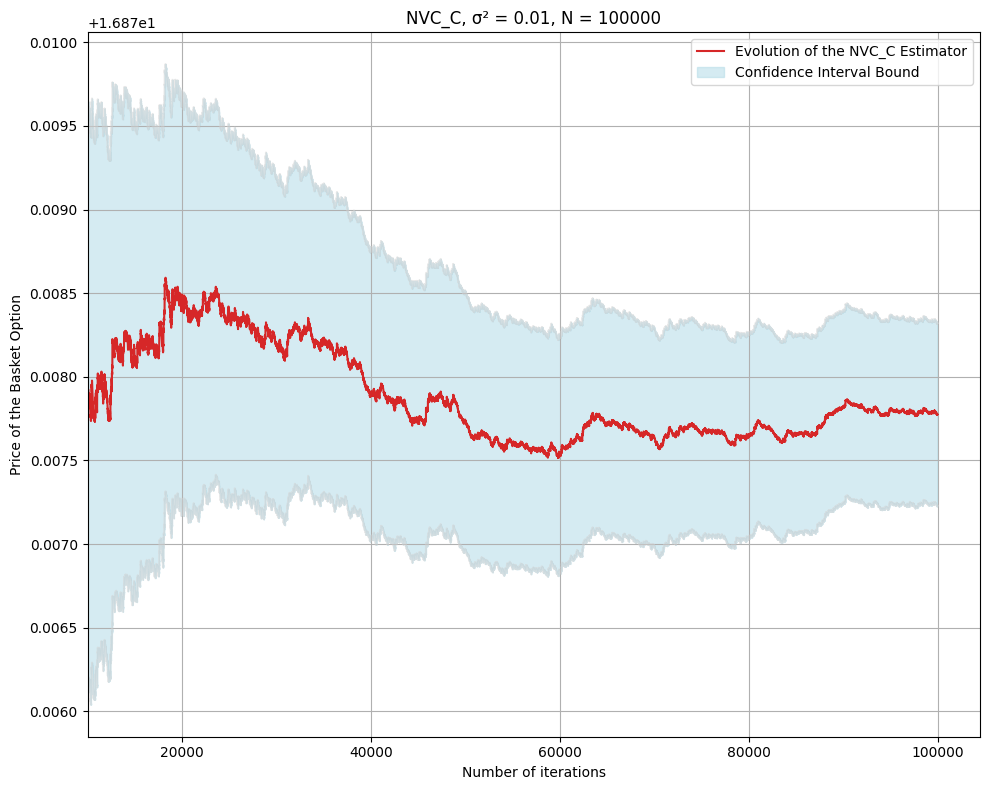

In [8]:
monte_carlo_estimator_NVC_C, asymptotic_variance_NVC_C, bound = montecarlo(NVC_C, proba, with_interval_bounds = True)
x = np.arange(start_idx, len(monte_carlo_estimator_NVC_C))

upper_bound_NVC_C = monte_carlo_estimator_NVC_C + bound
lower_bound_NVC_C = monte_carlo_estimator_NVC_C - bound

fig,ax = plt.subplots(layout = "tight", figsize = (10,8))
ax.plot(x, monte_carlo_estimator_NVC_C[start_idx:], label = "Evolution of the NVC_C Estimator", color = "C3")
ax.plot(x, upper_bound_NVC_C[start_idx:], color = "lightgrey", alpha = 0.5)
ax.plot(x, lower_bound_NVC_C[start_idx:], color = "lightgrey", alpha = 0.5)
ax.fill_between(x, upper_bound_NVC_C[start_idx:], lower_bound_NVC_C[start_idx:], color='lightblue', alpha=0.5, label="Confidence Interval Bound")
ax.set_title(f"NVC_C, σ² = {asymptotic_variance_NVC_C:.2f}, N = {N}")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Price of the Basket Option")
ax.legend()
ax.grid(True)

plt.xlim(start_idx)
plt.show()

A comparison of the four estimators plotted on the same graph, after half of the realisations. It may seem that the Monte Carlo estimator is not converging, but in reality, this is just due to its very high variance.

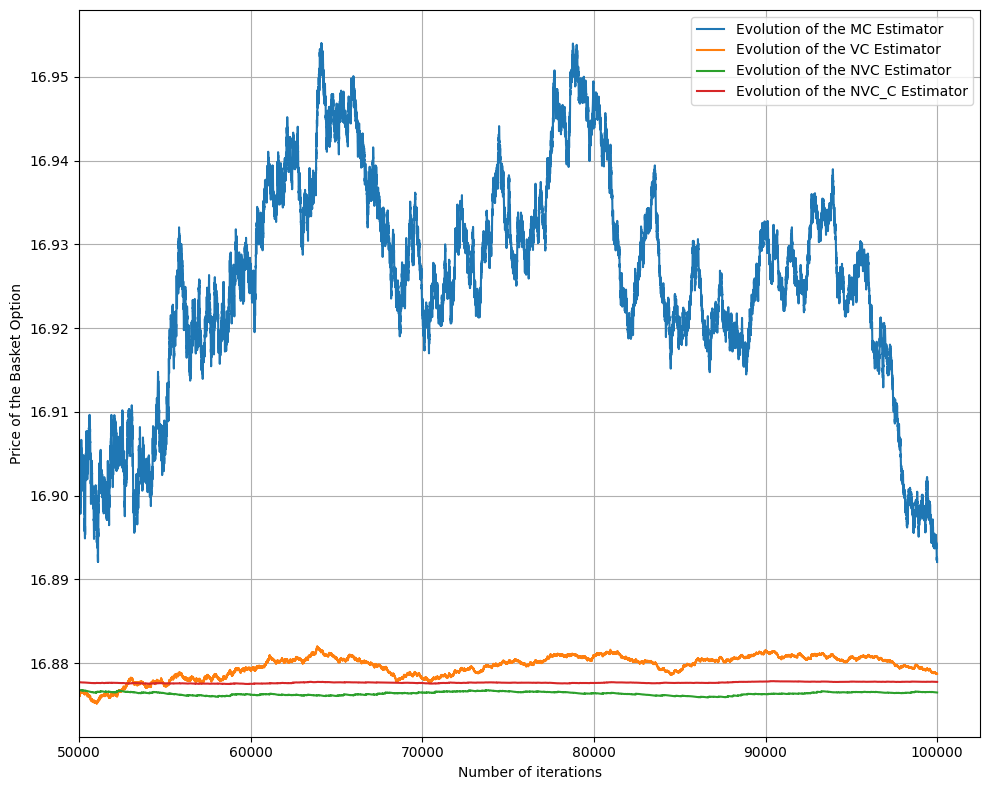

In [9]:
half_idx = int(N/2)
x = np.arange(half_idx, len(monte_carlo_estimator_NVC_C))

fig,ax = plt.subplots(layout = "tight", figsize = (10,8))
ax.plot(x, monte_carlo_estimator[half_idx:], label = "Evolution of the MC Estimator", color = "C0")
ax.plot(x, monte_carlo_estimator_VC[half_idx:], label = "Evolution of the VC Estimator", color = "C1")
ax.plot(x, monte_carlo_estimator_NVC[half_idx:], label = "Evolution of the NVC Estimator", color = "C2")
ax.plot(x, monte_carlo_estimator_NVC_C[half_idx:], label = "Evolution of the NVC_C Estimator", color = "C3")

ax.set_xlabel("Number of iterations")
ax.set_ylabel("Price of the Basket Option")
ax.legend()
ax.grid(True)

plt.xlim(half_idx)
plt.show()

In [10]:
print(f"MC / VC : {asymptotic_variance / asymptotic_variance_VC}")
print(f"MC / NVC : {asymptotic_variance / asymptotic_variance_NVC}")
print(f"MC / NVC_C : {asymptotic_variance / asymptotic_variance_NVC_C}")

MC / VC : 222.67502770372155
MC / NVC : 8212.222819734874
MC / NVC_C : 59743.42907013232


# Comparaison

In this section, we study how the effectiveness of the variance reduction methods changes when we vary the initial parameters. For example, we analyze how the methods perform when the time horizon is increased or decreased. We measure effectiveness using two indicators: the asymptotic variance and the computational effort, defined as the product of the asymptotic variance and the time required to compute each method. The second indicator may be more interesting in practice, as it accounts for both accuracy and computational cost. We will study the results in the PDF 

## The Strike

First, we can see how the performance of our reduction method behaves when the Strike is varying.

In [11]:
K_vec = np.array([K for K in range(100, 280, 10)])

a_var = []
t_vec = []


for j, k in enumerate(K_vec):
    
    var = []
    temp  = montecarlo_estimators(N, d, S0, sigma, r, T, k, w, R, True)

    for i in range(4):
        m, v = montecarlo(temp[i], proba)
        var.append(v)
           
    a_var.append(var)
    t_vec.append(temp[-1])
    
    
a_var = np.array(a_var)
t_vec = np.array(t_vec)

ratio = (a_var[:, [0]] / a_var)[:,1:]
cost = a_var * t_vec
ratio_cost = (cost[:, [0]] / cost)[:,1:]

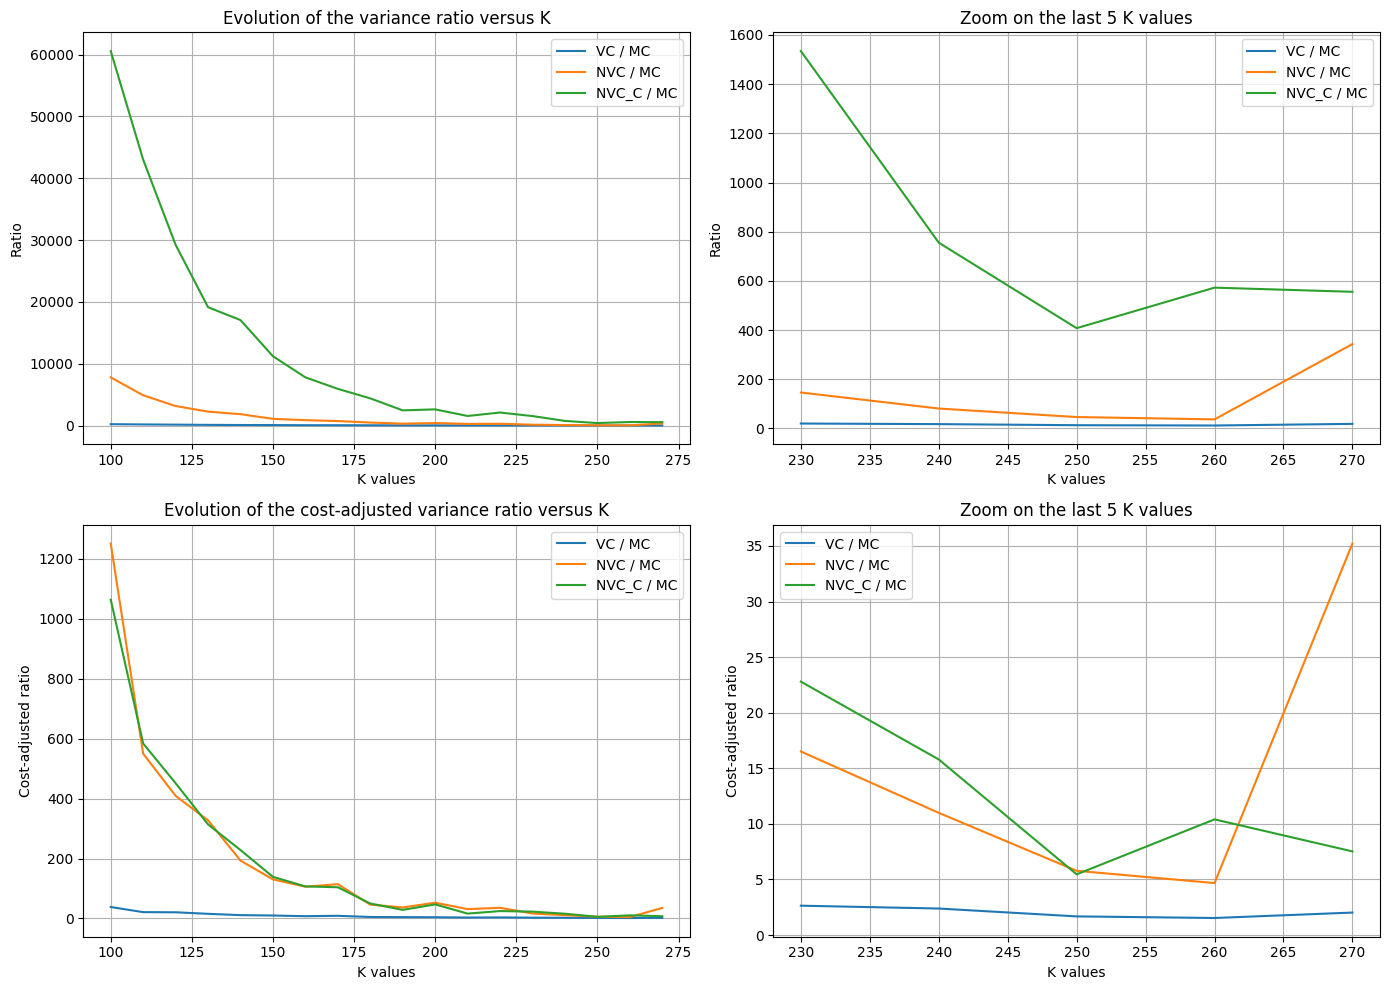

In [12]:
plot_variance_ratios(K_vec, ratio, ratio_cost, 'K')

## Time horizon

Let's investigate how the performance of our reduction method behaves when the time horizon varies

In [13]:
T_vec = [0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4]

In [14]:
a_var = []
t_vec = []

for j, t in enumerate(T_vec):

    var = []
    temp  = montecarlo_estimators(N, d, S0, sigma, r, t, K, w, R, True)

    for i in range(4):
        m, v = montecarlo(temp[i], proba)
        var.append(v)
           
    a_var.append(var)
    t_vec.append(temp[-1])
    
    
a_var = np.array(a_var)
t_vec = np.array(t_vec)

ratio = (a_var[:, [0]] / a_var)[:,1:]
cost = a_var * t_vec
ratio_cost = (cost[:, [0]] / cost)[:,1:]

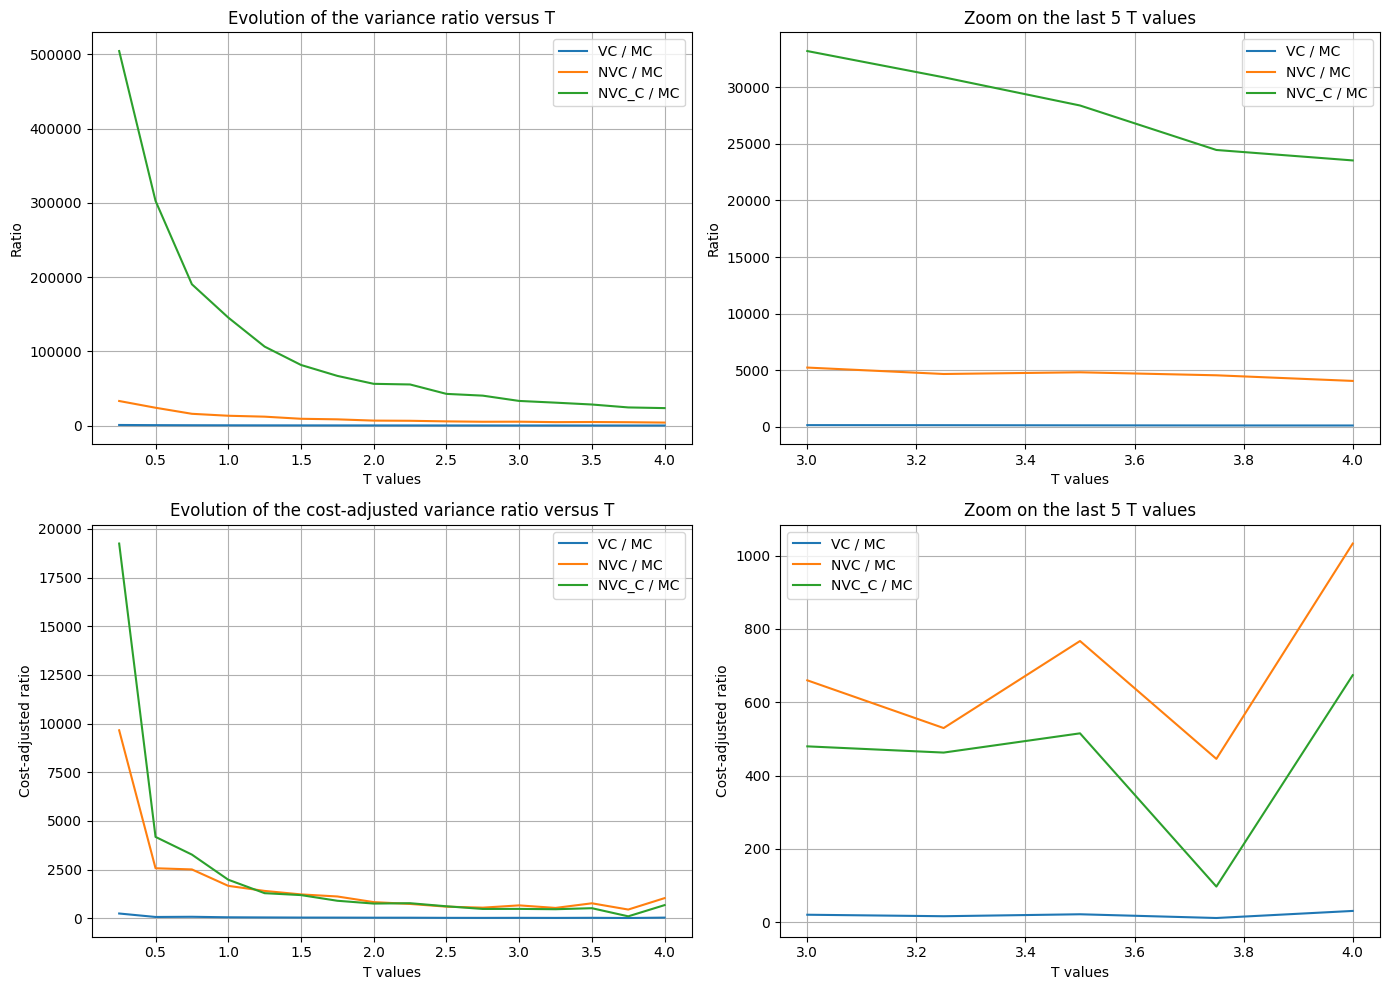

In [15]:
plot_variance_ratios(T_vec, ratio, ratio_cost, 'T')

## Conclusion

The variance reduction methods studied show varying effectiveness depending on the parameters. Overall, NVC and NVC C provide the strongest variance reduction, but the computational cost of NVC C should not be overlooked. The analysis also highlights that their efficiency tends to decrease for higher strikes, longer time horizons.